# **Common Test – Classification of Gravitational Lensing Images**
### **Introduction**

Gravitational Lensing occurs when an extremely massive celestial body causes curvature in spacetime, visibly bending the light around it. *Gravitational Lens* is the term used to refer to these bodies. Basically, **the light from sources like other galaxies and stars are redirected around the gravitational lens, making the light look “bent”**. A famous example of this can be seen in the theorized black hole images

This was *first theorised by Einstein* in his General Theory of Relativity, where he described how space around mass concentrations get distorted.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **Dataset**
- 10,000 images of the class “no”
    - **No Substructure** – smooth and symmetric lensing pattern
- 10,000 images of the class “sphere”
    - **Subhalo Substructure** – small distortions due to subhalos
- 10,000 images of the class “vortex”
    - **Vortex Substructure** – complex, swirling distortions caused by turbulent masses, potentially influenced by strong gravitational interactions or other forces.

In [4]:
!unzip -q /content/drive/MyDrive/dataset.zip -d /content/data

In [5]:
path = '/content/data/dataset/train/'

**Visualizing The Data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(149.5), np.float64(149.5), np.float64(-0.5))

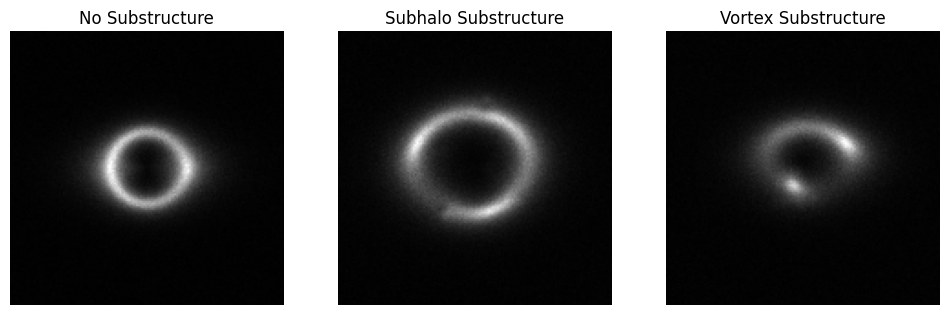

In [ ]:
sample_no = np.squeeze(np.load(path+'no/996.npy'))
sample_sphere = np.squeeze(np.load(path+'sphere/996.npy'))
sample_vort = np.squeeze(np.load(path+'vort/996.npy'))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(sample_no, cmap="gray")
axes[0].set_title("No Substructure")
axes[0].axis("off")

axes[1].imshow(sample_sphere, cmap="gray")
axes[1].set_title("Subhalo Substructure")
axes[1].axis("off")

axes[2].imshow(sample_vort, cmap="gray")
axes[2].set_title("Vortex Substructure")
axes[2].axis("off")

**Loading the training data into a pytorch dataset object**

Image numpy arrays are **converted to tensors** before converting into a dataset

In [40]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [8]:
def npy_loader(path):
  sample = torch.from_numpy(np.load(path))
  return sample.float()

dataset = datasets.DatasetFolder(
  root=path,
  loader=npy_loader,
  extensions=['.npy']
)

In [9]:
dataset

Dataset DatasetFolder
    Number of datapoints: 30000
    Root location: /content/data/dataset/train/

In [10]:
class_names = dataset.classes
print(f"Classes: {class_names}")

Classes: ['no', 'sphere', 'vort']


In [11]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

## **The ResNet Model**
- ResNets are **deeper networks than typical CNNs** and have lesser number of trainable parameters, making it better, faster, and more efficient to train.

- **Incredible training and stable validation loss curves**, ability to generalize and avoid overfitting, and simplicity in architecture make it an ideal model to train for this problem statement!


Why custom architecture?
- The PyTorch pretrained ResNet model has a lot of restrictions with respect to the image size, number of layers, trained classes, etc.

- Another reason for experimenting with the core ResNet architecture was **curiosity**! To explore how it essentially works and how it can be fine-tuned to be solve the task at hand.

### **The Main ResNet Architecture**
- **Initial Block** = 7x7 Convolution layer with a stride of 2

- **Max Pooling** is performed on the initial block to get it to 3x3 size output

- **Residual Layers** = 4 Residual blocks with increasing number of planes (filters)
    - First Layer = 3 Blocks
    - Second Layer = 4 Blocks
    - Third Layer = 6 Blocks
    - Fourth Layer = 3 Blocks

- **Adaptive Average Pooling** = to downsample the output of the residual layers to a 1x1 form so that it can be fed to the fully connected layer

- **Fully Connected Layer** = maps extracted features to the required classes

In [42]:
import torch
import torch.nn as nn

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        '''
            Input:
                block - residual block class
                layers - number of residual blocks in each of the four layers
                num_classes - number of classes, default 3 (specific to this problem statement)
        '''
        super(ResNet, self).__init__()
        self.inplanes = 64

        # initial layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # layers of residual blocks
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
            Input:
                block - residual block class
                planes - number of output channels of the layer (number of filters)
                blocks - number of residual blocks in the layer
                stride - to control downsampling

            Output:
                all blocks are combined into an nn.Sequential module
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        '''
            Input:
                x - image tensor with (batch size, channels, height, width)

            Output:
                x - (batch size, number of output classes), raw logit values
        '''
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### **The Residual Block**
- It has **2 batch-normalized convolution layers** of size 3x3 each, and is downsampled depending on the stride provided

- ReLU is applied to the final output of this block.

- This is the block that is used to **tackle Vanishing Gradients** and skip connections to learn better.


In [ ]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            '''
                Input:
                    in_channels - number of input channels
                    out_channels - number of output channels
                    stride - controls downsampling, for the first convolution
                    downsample - downsampling layer to match dimenstions for skip connection
            '''

            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True))
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU(inplace=True)
            self.out_channels = out_channels

        def forward(self, x):
            '''
                Input:
                    x - image tensor with (batch size, input channels, height, width)

                Output:
                    x - (batch size, output channels, new height, new width) 
            '''
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            return self.relu(out)

## **The Training Process**

In [27]:
num_epochs = 45
batch_size = 24

# Finally, it is a ResNet 34 like model with a total of 34 convolution layers (6+8+12+6)
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device) # each layer has two convolution layers

# loss funtion
criterion = nn.CrossEntropyLoss() # measure the classification model’s performance

# optimization
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.001, momentum = 0.9) # updates model weights based on the gradient of loss function with respect to the parameters

In [ ]:
import gc
from tqdm import tqdm

# training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for (images, labels) in tqdm(train_loader): # iterate over batches
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # track loss

        # to prevent gpu from crashing
        del images, labels, outputs
        torch.cuda.empty_cache()

    # loss per epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

100%|██████████| 938/938 [01:34<00:00,  9.90it/s]


Epoch [1/48], Average Loss: 1.1674


100%|██████████| 938/938 [01:34<00:00,  9.90it/s]


Epoch [2/48], Average Loss: 1.1325


100%|██████████| 938/938 [01:34<00:00,  9.98it/s]


Epoch [3/48], Average Loss: 1.1199


100%|██████████| 938/938 [01:35<00:00,  9.85it/s]


Epoch [4/48], Average Loss: 1.1133


100%|██████████| 938/938 [01:34<00:00,  9.96it/s]


Epoch [5/48], Average Loss: 1.1091


100%|██████████| 938/938 [01:35<00:00,  9.87it/s]


Epoch [6/48], Average Loss: 1.1065


100%|██████████| 938/938 [01:34<00:00,  9.87it/s]


Epoch [7/48], Average Loss: 1.1049


100%|██████████| 938/938 [01:33<00:00, 10.06it/s]


Epoch [8/48], Average Loss: 1.1027


100%|██████████| 938/938 [01:34<00:00,  9.91it/s]


Epoch [9/48], Average Loss: 1.1017


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Epoch [10/48], Average Loss: 1.0992


100%|██████████| 938/938 [01:32<00:00, 10.09it/s]


Epoch [11/48], Average Loss: 1.0978


100%|██████████| 938/938 [01:33<00:00, 10.05it/s]


Epoch [12/48], Average Loss: 1.0949


100%|██████████| 938/938 [01:35<00:00,  9.81it/s]


Epoch [13/48], Average Loss: 1.0918


100%|██████████| 938/938 [01:35<00:00,  9.85it/s]


Epoch [14/48], Average Loss: 1.0864


100%|██████████| 938/938 [01:34<00:00,  9.91it/s]


Epoch [15/48], Average Loss: 1.0751


100%|██████████| 938/938 [01:36<00:00,  9.76it/s]


Epoch [16/48], Average Loss: 1.0586


100%|██████████| 938/938 [01:35<00:00,  9.86it/s]


Epoch [17/48], Average Loss: 1.0319


100%|██████████| 938/938 [01:34<00:00,  9.88it/s]


Epoch [18/48], Average Loss: 0.9955


100%|██████████| 938/938 [01:35<00:00,  9.78it/s]


Epoch [19/48], Average Loss: 0.9621


100%|██████████| 938/938 [01:35<00:00,  9.78it/s]


Epoch [20/48], Average Loss: 0.8980


100%|██████████| 938/938 [01:35<00:00,  9.87it/s]


Epoch [21/48], Average Loss: 0.7968


100%|██████████| 938/938 [01:35<00:00,  9.85it/s]


Epoch [22/48], Average Loss: 0.6832


100%|██████████| 938/938 [01:35<00:00,  9.78it/s]


Epoch [23/48], Average Loss: 0.5837


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Epoch [24/48], Average Loss: 0.4892


100%|██████████| 938/938 [01:35<00:00,  9.84it/s]


Epoch [25/48], Average Loss: 0.3973


100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Epoch [26/48], Average Loss: 0.3271


100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Epoch [27/48], Average Loss: 0.2751


100%|██████████| 938/938 [01:36<00:00,  9.74it/s]


Epoch [28/48], Average Loss: 0.2469


100%|██████████| 938/938 [01:35<00:00,  9.82it/s]


Epoch [29/48], Average Loss: 0.2139


100%|██████████| 938/938 [01:33<00:00, 10.06it/s]


Epoch [30/48], Average Loss: 0.1872


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Epoch [31/48], Average Loss: 0.1641


100%|██████████| 938/938 [01:35<00:00,  9.78it/s]


Epoch [32/48], Average Loss: 0.1528


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Epoch [33/48], Average Loss: 0.1296


100%|██████████| 938/938 [01:34<00:00,  9.92it/s]


Epoch [34/48], Average Loss: 0.1118


100%|██████████| 938/938 [01:35<00:00,  9.87it/s]


Epoch [35/48], Average Loss: 0.1000


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Epoch [36/48], Average Loss: 0.0876


100%|██████████| 938/938 [01:35<00:00,  9.82it/s]


Epoch [37/48], Average Loss: 0.0773


100%|██████████| 938/938 [01:35<00:00,  9.85it/s]


Epoch [38/48], Average Loss: 0.0725


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Epoch [39/48], Average Loss: 0.0527


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Epoch [40/48], Average Loss: 0.0562


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Epoch [41/48], Average Loss: 0.0450


100%|██████████| 938/938 [01:34<00:00,  9.90it/s]


Epoch [42/48], Average Loss: 0.0465


100%|██████████| 938/938 [01:34<00:00,  9.88it/s]


Epoch [43/48], Average Loss: 0.0348


100%|██████████| 938/938 [01:34<00:00,  9.92it/s]


Epoch [44/48], Average Loss: 0.0385


100%|██████████| 938/938 [01:35<00:00,  9.78it/s]


Epoch [45/48], Average Loss: 0.0271


100%|██████████| 938/938 [01:35<00:00,  9.78it/s]


Epoch [46/48], Average Loss: 0.0345


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Epoch [47/48], Average Loss: 0.0260


100%|██████████| 938/938 [01:36<00:00,  9.70it/s]

Epoch [48/48], Average Loss: 0.0237


## **Testing the model on validation data**

Loading the validation data

In [38]:
val_data = datasets.DatasetFolder(
  root='/content/data/dataset/val',
  loader=npy_loader,
  extensions=['.npy']
)

In [39]:
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [29]:
model.eval() # evaluation mode
y_true = []
y_pred = []
probs = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

        del images, labels, outputs

100%|██████████| 235/235 [00:19<00:00, 12.23it/s]


Accuracy

In [ ]:
# accuracy
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.9165333333333333

Confusion Matrix

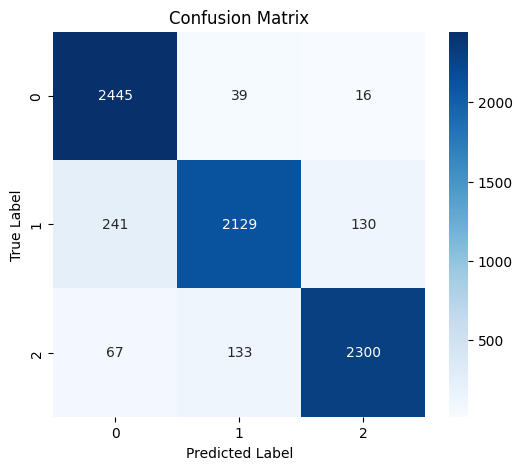

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ROC and AUC metrics

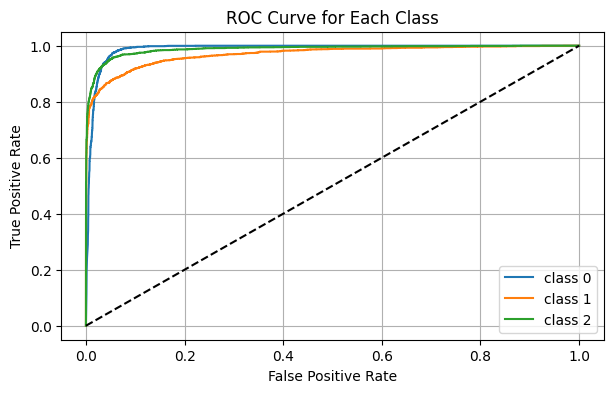

In [ ]:
enc = label_binarize(y_true, classes=[0, 1, 2])  # labels to one-hot encoding

# false positive rate, true positive rate, auc values for each class
fpr, tpr, auc_val = {}, {}, {}

plt.figure(figsize=(7, 4))
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(enc[:, i], np.array(probs)[:, i])
    auc_val[i] = auc(fpr[i], tpr[i]) # calculate the AUC scores with respect to the fpr and tpr

    plt.plot(fpr[i], tpr[i], label='class '+str(i)) # ROC curve for each class

plt.plot([0, 1], [0, 1], 'k--') # the random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.grid()

In [35]:
for i in range(3):  # 3 class
    print(f"AUC Score for Class {i}: {auc_val[i]:.3f}")

AUC Score for Class 0: 0.988
AUC Score for Class 1: 0.970
AUC Score for Class 2: 0.988


## **Saving the model**

In [36]:
save_path = "/content/classification_model.pth"

model.eval()
torch.save(model.state_dict(), save_path)
print(f"model saved!")

model saved!


and finally ....
### *The Training Weights of the model*

In [37]:
mod = ResNet(ResidualBlock, [3, 4, 6, 3])
mod.load_state_dict(torch.load('/content/classification_model.pth', weights_only=True))
mod.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)